# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

Status: 200
  Rank                 Song                 Artist(s) Streams (billions)  \
0    1    "Blinding Lights"                The Weeknd              5.052   
1    2       "Shape of You"                Ed Sheeran              4.574   
2    3            "Starboy"  The Weeknd and Daft Punk              4.119   
3    4  "Someone You Loved"             Lewis Capaldi              4.071   
4    5    "Sweater Weather"         The Neighbourhood              4.059   

        Release date Ref.  
0   29 November 2019  [1]  
1     6 January 2017  [2]  
2  21 September 2016  [3]  
3    8 November 2018  [4]  
4    3 December 2012  [5]  
   Rank                                       Song                    Artist  \
0     1                          "Blinding Lights"                The Weeknd   
1     2                             "Shape of You"                Ed Sheeran   
2     3                                  "Starboy"  The Weeknd and Daft Punk   
3     4                        "Someone You

/tmp/ipykernel_6917/2807176414.py:35: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


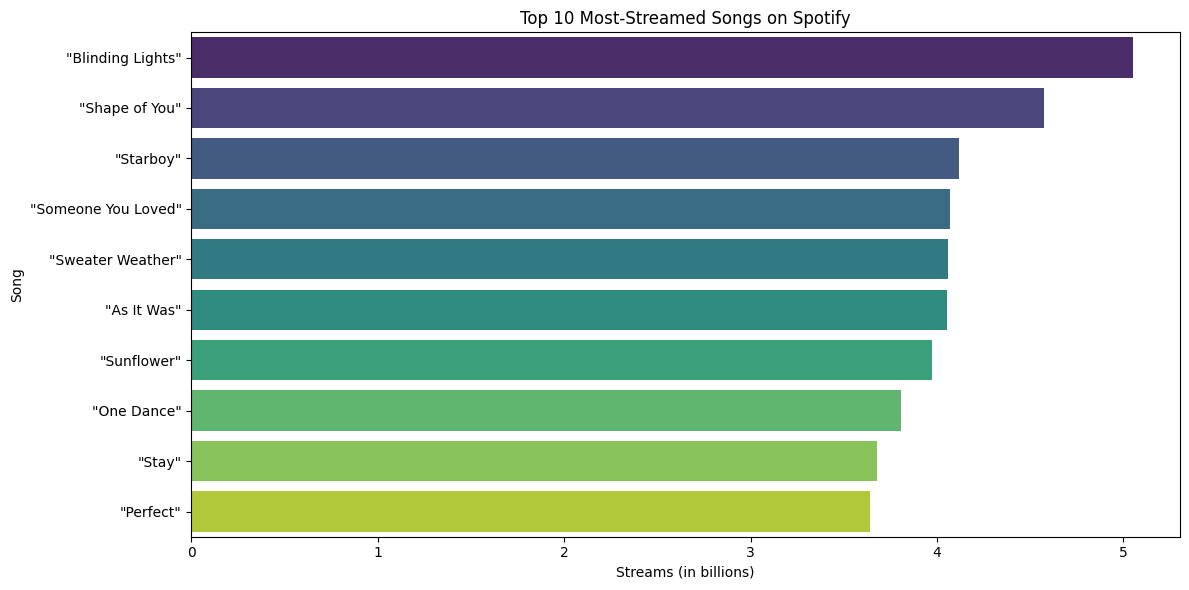

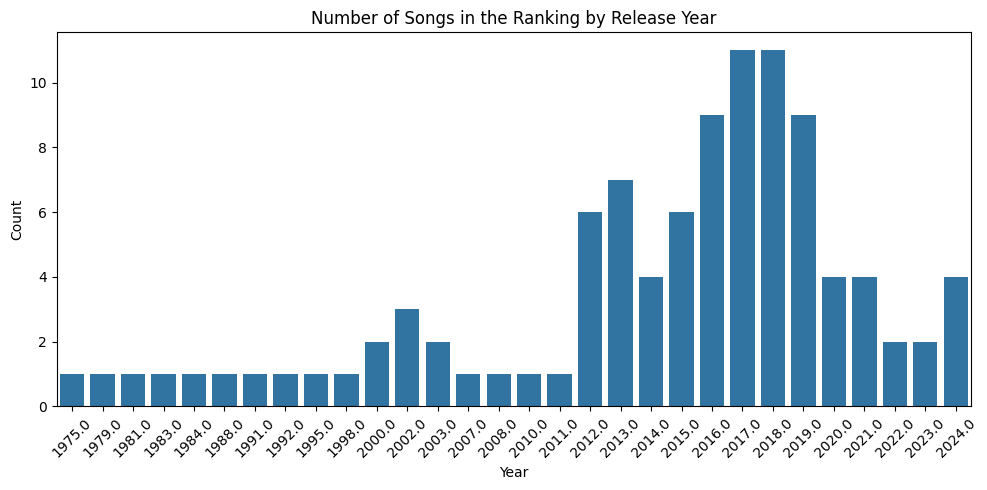

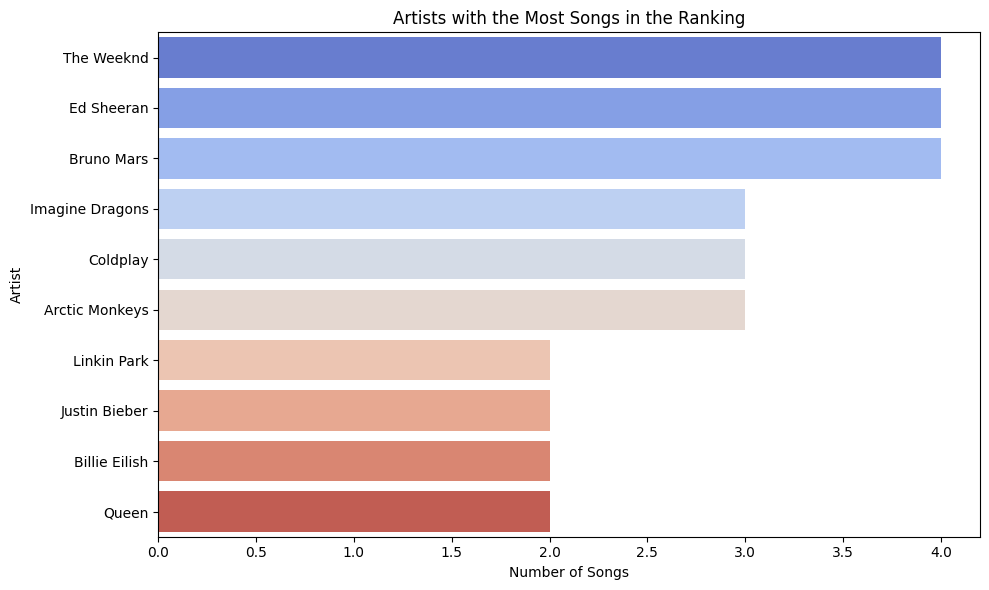

In [27]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records"

# Pausa (opciona, comportamiento mas humano)
time.sleep(10)

# User-Agent realista + timeout  ## para que la solicitud parezca mas humana
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36 (compatible; BootcampScraper/1.0)"
    )
}

response = requests.get(url, headers=headers, timeout=20)
if response:
    print("Status:", response.status_code)
else:
    response.raise_for_status()   # lanza error si no es 200

soup = BeautifulSoup(response.text, "html.parser") # una vez tengamos la respuesta lo pasamos a arbol del DOM anidado con html.parser para poder encontrar la informacion que necesitamos en este acso tag"table", y class_="wikitable"
tables = soup.find_all("table", class_="wikitable")

table = tables[0]
# lo convertimos en df se usa se convierte nuevamente en str para que pd lo pueda leer y [0] que especifica la posicion en la que esta la tabla que necesito
df = pd.read_html(str(table))[0]

print(df.head())

dfc = df.copy() # Se crea una copia

#renombro columnas
dfc.columns = ["Rank", "Song", "Artist", "Streams (billions)", "Date released", "Reference"]

# Se limpia los string 

dfc["Song"] = dfc["Song"].str.replace(r"\[.*?\]", "", regex=True)
dfc["Artist"] = dfc["Artist"].str.replace(r"\[.*?\]", "", regex=True)

# filtrar filas que cumpla con regex
dfc = dfc[dfc["Streams (billions)"].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)].copy()

# comvertir streams a decimales
dfc["Streams (billions)"] = dfc["Streams (billions)"].astype(float)

# convertir fechas a date time
dfc["Date released"] = pd.to_datetime(dfc["Date released"], errors="coerce")

print(dfc)

# conectar a SQL
conct = sqlite3.connect("spotify_top_songs.db")

# Crear tabla en sql

dfc.to_sql("most_streamed", conct, if_exists="replace", index=False)
cursor = conct.cursor()

#Cuentas cuantas filas tiene la base de datos
cursor.execute("SELECT COUNT(*) FROM most_streamed")
print("Rows inserted:", cursor.fetchone()[0])

conct.commit()
conct.close()

# Grafico 1: Top 10 mas canciones con streams
top10 = dfc.nlargest(10, "Streams (billions)")
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Streams (billions)", y="Song", hue="Song", palette="viridis", legend=False)
plt.title("Top 10 Most-Streamed Songs on Spotify")
plt.xlabel("Streams (in billions)")
plt.ylabel("Song")
plt.tight_layout()
plt.show()

# Numero de canciones lanzadas por año
df["Year"] = dfc["Date released"].dt.year
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Year", order=sorted(df["Year"].dropna().unique()))
plt.title("Number of Songs in the Ranking by Release Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Chart 3: Artistas con ,as canciones en el rankin
artists = dfc["Artist"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=artists.values, y=artists.index, hue=artists.index, palette="coolwarm", legend=False)
plt.title("Artists with the Most Songs in the Ranking")
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()